# Discussion of the GP marginal likelihood upper bound
Mark van der Wilk, Augustus 2017

Adapted to Pytorch by Thomas Viehmann

See [gp_upper](https://github.com/markvdw/gp_upper) for code to tighten the upper bound through optimisation, and a more comprehensive discussion.

In [27]:
%matplotlib inline
import numpy
from matplotlib import pyplot
import pandas

import sys, os
sys.path.append(os.path.join(os.getcwd(),'..'))

pyplot.style.use('ggplot')
import IPython

import torch
from torch.autograd import Variable

import candlegp

(torch.Size([50, 1]), torch.Size([50]))

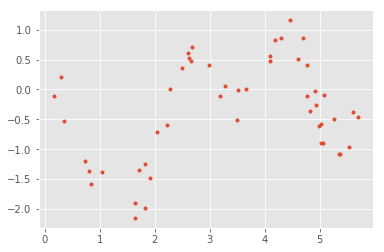

In [28]:
if 0:
    N = 20
    X = torch.rand(N,1).double()
    Y = (torch.sin(12*X) + 0.6*torch.cos(25*X) + torch.randn(N,1).double()*0.1+3.0).squeeze(1)
    pyplot.figure()
    pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)
else:
    x = pandas.read_csv(r"data/snelson_train_inputs", header=None).as_matrix()[::4]
    y = pandas.read_csv(r"data/snelson_train_outputs", header=None).as_matrix()[::4]
    X = torch.from_numpy(x).double()
    Y = torch.from_numpy(y).double().squeeze()
    pyplot.plot(x,y,'.')
X.size(), Y.size()

In [29]:
def plot_model(m, name=""):
    pX = np.linspace(-3, 9, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, 'x')
    plt.plot(pX, pY)
    try:
        plt.plot(m.Z.value, m.Z.value * 0, 'o')
    except AttributeError:
        pass
    two_sigma = (2.0 * pYv ** 0.5)[:, 0]
    plt.fill_between(pX[:, 0], pY[:, 0] - two_sigma, pY[:, 0] + two_sigma, alpha=0.15)
    lml = -m._objective(m.get_free_state())[0]
    plt.title("%s (lml = %f)" % (name, lml))
    return lml

## Full model

0 : 59.02330388085118
5 : 24.084614892792732
10 : 23.968649733178797
15 : 23.96669303279061
20 : 23.966658183048185
25 : 23.96665759428826
30 : 23.966657589737324
35 : 23.966657585621537
40 : 23.966657581899476
45 : 23.966657578534132


Parameter,Value,Prior,ParamType
kern.variance,[ 0.90050402],None,PositiveParam
kern.lengthscales,[ 0.58250756],None,PositiveParam
likelihood.variance,[ 0.07428933],None,PositiveParam


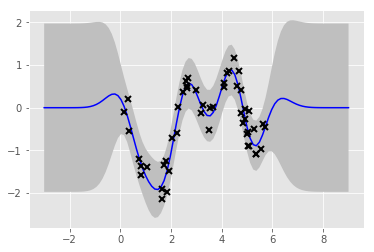

In [30]:
def optimize(m, lr=5e-3, it=50):
    opt = torch.optim.LBFGS(m.parameters(), lr=lr, max_iter=40)
    def eval_model():
        obj = m()
        opt.zero_grad()
        obj.backward()
        return obj

    for i in range(it):
        obj = m()
        opt.zero_grad()
        obj.backward()
        opt.step(eval_model)
        if i%5==0:
            print(i,':',obj.data[0])
    return -obj.data[0]

k = candlegp.kernels.RBF(1, lengthscales=torch.DoubleTensor([1.0]),variance=torch.DoubleTensor([1.0]))
m = candlegp.models.GPR(Variable(X), Variable(Y.unsqueeze(1)), kern=k)
#m.likelihood.variance.set(0.01)

full_lml = optimize(m, lr=1e-2)

xstar = torch.linspace(-3,9,100).double()
mu, var = m.predict_y(Variable(xstar.unsqueeze(1)))
cred_size = (var**0.5*2).squeeze(1)
mu = mu.squeeze(1)
pyplot.plot(xstar.numpy(),mu.data.numpy(),'b')
pyplot.fill_between(xstar.numpy(),mu.data.numpy()+cred_size.data.numpy(), mu.data.numpy()-cred_size.data.numpy(),facecolor='0.75')
pyplot.plot(X.numpy(), Y.numpy(), 'kx', mew=2)

m

## Upper bounds for sparse variational models
As a first investigation, we compute the upper bound for models trained using the sparse variational GP approximation.

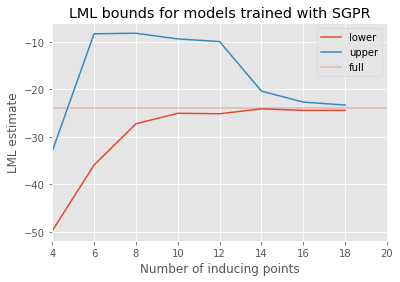

In [31]:
Ms = numpy.arange(4, 20, 2)
vfe_lml = []
vupper_lml = []
vfe_hyps = []
for M in Ms:
    Zinit = X[:M, :].clone()
    k = candlegp.kernels.RBF(1, lengthscales=torch.DoubleTensor([1.0]),variance=torch.DoubleTensor([1.0]))
    m = candlegp.models.SGPR(Variable(X), Variable(Y.unsqueeze(1)), k, Zinit)
    m.likelihood.variance.set(0.01)
    optimize(m, lr=1e-3, it=100)
    vfe_lml.append(-m.objective().data[0])
    vupper_lml.append(m.compute_upper_bound().data[0])
    vfe_hyps.append(m.state_dict())
    print("%i" % M, end=" ")
    IPython.display.clear_output()
    pyplot.figure()
    pyplot.plot(Ms[:len(vfe_lml)], vfe_lml, label="lower")
    pyplot.plot(Ms[:len(vfe_lml)], vupper_lml, label="upper")
    pyplot.axhline(full_lml, label="full", alpha=0.3)
    pyplot.xlabel("Number of inducing points")
    pyplot.ylabel("LML estimate")
    pyplot.legend()
    pyplot.title("LML bounds for models trained with SGPR")
    pyplot.xlim(4,20)
    pyplot.show()
vfe_hyps = pandas.DataFrame(vfe_hyps)

We see that the lower bound increases as more inducing points are added. Note that the upper bound does _not_ monotonically decrease! This is because as we train the sparse model, we also get better estimates of the hyperparameters. The upper bound will be different for this different setting of the hyperparameters, and is sometimes looser. The upper bound also converges to the true lml slower than the lower bound.

## Upper bounds for fixed hyperparameters
Here, we train sparse models with the hyperparameters fixed to the optimal value found previously.

In [7]:
fMs = numpy.arange(3, 20, 1)
fvfe_lml = []  # Fixed vfe lml
fvupper_lml = []  # Fixed upper lml
for M in fMs:
    Zinit = vfe.Z.value[:M, :].copy()
    Zinit = np.vstack((Zinit, X[np.random.permutation(len(X))[:(M - len(Zinit))], :].copy()))
    init_params = vfe.get_parameter_dict()
    init_params['model.Z'] = Zinit
    vfe = gpflow.models.SGPR(X, Y, gpflow.kernels.RBF(1), Zinit)
    vfe.set_parameter_dict(init_params)
    vfe.kern.fixed = True
    vfe.likelihood.fixed = True
    vfe.optimize()
    
    fvfe_lml.append(-vfe._objective(vfe.get_free_state())[0])
    fvupper_lml.append(vfe.compute_upper_bound())
    print("%i" % M, end=" ")

NameError: name 'np' is not defined

In [ ]:
plt.plot(fMs, fvfe_lml, label="lower")
plt.plot(fMs, fvupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
plt.legend()

Now, as the hyperparameters are fixed, the bound _does_ monotonically decrease. We chose the optimal hyperparameters here, but the picture should be the same for any hyperparameter setting. This shows that we increasingly get a better estimate of the marginal likelihood as we add more inducing points.

## A tight estimate bound does not imply a converged model

In [ ]:
vfe = gpflow.models.SGPR(X, Y, gpflow.kernels.RBF(1), X[None, 0, :].copy())
vfe.optimize()
print("Lower bound: %f" % -vfe._objective(vfe.get_free_state())[0])
print("Upper bound: %f" % vfe.compute_upper_bound())

In this case we show that for the hyperparameter setting, the bound is very tight. However, this does _not_ imply that we have enough inducing points, but simply that we have correctly identified the marginal likelihood for this particular hyperparameter setting. In this specific case, where we used a single inducing point, the model collapses to not using the GP at all (lengthscale is really long to model only the mean). The rest of the variance is explained by noise. This GP can be perfectly approximated with a single inducing point.

In [ ]:
vfe

This can be diagnosed by showing that there are other hyperparameter settings with higher upper bounds. This indicates that there may be better hyperparameter settings, but we cannot identify them due to the lack of inducing points. An example of this can be seen in the previous section.